In [1]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap
from models import HD_cell_L1, PC_cell_L2

#for plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
import pycircstat.descriptive as cd

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

In [2]:
def simulate_honeycomb_movement(
    total_time=1, 
    dt=0.01, 
    move_prob=0.95, 
    drift_factor=0.0, 
    velocity=0.5, 
    rotation_speed=np.pi / 50,
    stick_length=0.2,
    goal_loc=[0, 0]
):
    
    env_size = 1.0
    time_steps = int(total_time / dt)

    pos_A = np.array([env_size / 2, env_size / 2])
    angle = 0
    pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])
    move_angle = np.random.uniform(-np.pi, np.pi)

    A_trajectory = []   
    B_trajectory = []
    head_directions = []
    rotation_phases = []
    rotation_direction_log = []
    time_list = []
    breakTimepoints = []  # Initialise list


    step_count = 0
    current_time = 0
    just_rotated = False  # New flag to prevent back-to-back rotations

    while step_count < time_steps:
        if (np.random.rand() < move_prob and not just_rotated) or just_rotated:
            
            move_angle = (drift_factor * move_angle) + ((1 - drift_factor) * np.random.uniform(-np.pi, np.pi))
            step_size = velocity * dt
            new_pos_A = pos_A + step_size * np.array([np.cos(move_angle), np.sin(move_angle)])
            new_pos_A = np.clip(new_pos_A, 0, env_size)
            pos_A = new_pos_A
            pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

            A_trajectory.append(pos_A.copy())
            B_trajectory.append(pos_B.copy())
            head_directions.append(angle)
            rotation_phases.append(False)
            rotation_direction_log.append(0)
            time_list.append(current_time)

            step_count += 1
            current_time += dt
            just_rotated = False  # Reset flag after movement
        else:
            # Randomly choose rotation direction: +1 (CW) or -1 (CCW)
            direction_flag = np.random.choice([1, -1])
            rotation_duration = int(np.random.uniform(0.3, 1.0) / dt)

            for _ in range(min(rotation_duration, time_steps - step_count)):
                angle -= direction_flag * rotation_speed  # CW = -rotation
                angle = (angle + np.pi) % (2 * np.pi) - np.pi
                pos_B = pos_A + stick_length * np.array([np.cos(angle), np.sin(angle)])

                # Check alignment with goal direction
                vec_to_goal = goal_loc - pos_A
                dir_to_goal = np.arctan2(vec_to_goal[1], vec_to_goal[0])
                angle_diff = ((angle - dir_to_goal + np.pi) % (2 * np.pi)) - np.pi  # Wrap to [-π, π]

                # if np.abs(angle_diff) < np.deg2rad(10):  # e.g. 5° threshold
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                # if (np.abs(angle_diff) > np.deg2rad(170)):
                #     breakTimepoints.append(current_time)  # Record the time when aligned
                #     break  # Stop rotation if aligned

                A_trajectory.append((pos_A.copy()+pos_B.copy())/2)
                B_trajectory.append(pos_B.copy())
                head_directions.append(angle)
                rotation_phases.append(True)
                rotation_direction_log.append(direction_flag)
                time_list.append(current_time)

                step_count += 1
                current_time += dt
                if step_count >= time_steps:
                    break
                
            just_rotated = True  # Mark that a rotation just occurred

    A_trajectory = np.array(A_trajectory)
    B_trajectory = np.array(B_trajectory)
    head_directions = np.array(head_directions)
    rotation_phases = np.array(rotation_phases)
    rotation_direction_log = np.array(rotation_direction_log)
    time_original = np.array(time_list)

    displacement = np.linalg.norm(np.diff(B_trajectory, axis=0), axis=1)
    speeds = np.concatenate(([0], displacement / dt))

    dt_new = 0.001
    time_upsampled = np.arange(0, time_original[-1] + dt_new, dt_new)

    interp_A_x = interp1d(time_original, A_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_A_y = interp1d(time_original, A_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_B_x = interp1d(time_original, B_trajectory[:, 0], kind='linear', fill_value="extrapolate")
    interp_B_y = interp1d(time_original, B_trajectory[:, 1], kind='linear', fill_value="extrapolate")
    interp_head_dir = interp1d(time_original, head_directions, kind='linear', fill_value="extrapolate")
    interp_speeds = interp1d(time_original, speeds, kind='linear', fill_value="extrapolate")

    # Interpolate all trajectories and parameters
    A_trajectory_upsampled = np.vstack((interp_A_x(time_upsampled), interp_A_y(time_upsampled))).T
    B_trajectory_upsampled = np.vstack((interp_B_x(time_upsampled), interp_B_y(time_upsampled))).T
    head_directions_upsampled = interp_head_dir(time_upsampled)
    speeds_upsampled = interp_speeds(time_upsampled)
    head_directions_upsampled = (head_directions_upsampled + np.pi) % (2 * np.pi) - np.pi

    interp_rotation_phase = interp1d(time_original, rotation_phases, kind='nearest', fill_value="extrapolate")
    rotation_phases_upsampled = interp_rotation_phase(time_upsampled).astype(bool)

    interp_rotation_dir = interp1d(time_original, rotation_direction_log, kind='nearest', fill_value="extrapolate")
    rotation_direction_upsampled = interp_rotation_dir(time_upsampled).astype(int)

    vec_to_goal = goal_loc - B_trajectory_upsampled
    Dir2Goal = np.arctan2(vec_to_goal[:, 1], vec_to_goal[:, 0])

    diff = np.diff(B_trajectory_upsampled, axis=0)
    Velocity = np.zeros_like(B_trajectory_upsampled)
    Velocity[:-1, :] = diff
    MVDirection = (np.arctan2(Velocity[:, 1], Velocity[:, 0]) + np.pi) % (2 * np.pi) - np.pi
    
    break_indices = np.searchsorted(time_upsampled, breakTimepoints)

    return (
        A_trajectory_upsampled,
        B_trajectory_upsampled,
        head_directions_upsampled,
        MVDirection,
        Dir2Goal,
        speeds_upsampled,
        rotation_phases_upsampled,
        time_upsampled,
        Velocity,
        rotation_direction_upsampled,
        break_indices
    )


## Section 1: Generate simple trajectory to test model parameters

2025-06-28 23:48:42.972330: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Running simulation...
Simulation progress: 0%


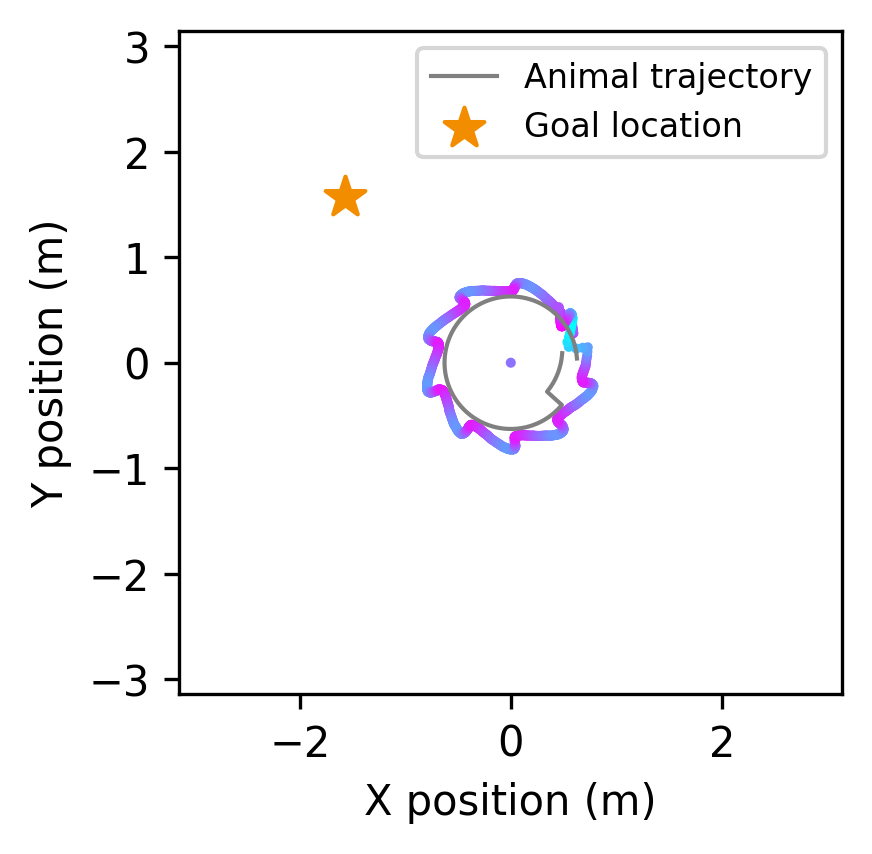

In [3]:
# np.random.seed(42)  # For reproducibility

#--------------------------simulate trajectory---------------------------
goal_loc = [-0.5*np.pi, 0.5*np.pi]  
goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

direction = 'clockwise' 
# Run the function to generate movement data
results = simulate_honeycomb_movement(total_time=1, 
                                    dt=0.01, 
                                    move_prob=0.70, 
                                    drift_factor=0.0, 
                                    velocity=6,
                                    rotation_speed=np.pi / 50,
                                    stick_length = 0.2,
                                    goal_loc=goal_loc_in_traj)

Animal_center_all, Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all, Rotation_direction_all, break_indices = results

Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all = Animal_speed_all/1000

#--------------------------simulate movement---------------------------

#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 5. #HD adaptation strength 
mbar_pc = 5. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.5
theta_hd_modulation = 0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0.5 # default 0.5; maximal 0.5,
Topdown_mod = 5.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=False)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.5,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    results = run(time_steps[i:i+simulate_time], 
                    Animal_location_all[i:i+simulate_time], 
                    MV_direction_all[i:i+simulate_time],
                    Animal_speed_all[i:i+simulate_time],
                    Dir2Goal_all[i:i+simulate_time])
    
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = results
    
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)
    
#--------------------------plot---------------------------

fig, ax  = plt.subplots(1, 1, figsize=(3,3), dpi=300)
num = 50
z_max = np.pi
time_steps = np.arange(len(Animal_location_all))
max_r_grid = np.max(pc_activity, axis=(1,2)) 

# Static plot for position and bump center in the second subplot (axs[1])
ax.plot(Animal_location_all[:, 0], Animal_location_all[:, 1], color='grey', linewidth=1, label='Animal trajectory')
ax.scatter(goal_loc[0], goal_loc[1], color='#F28D00', marker='*', s=100, label='Goal location')

sc = ax.scatter(
                pc_bumpcenter[:, 0],
                pc_bumpcenter[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=2,
        )

ax.set_aspect('equal')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-np.pi,np.pi)
ax.legend(fontsize=8)
ax.set_xlabel('X position (m)', fontsize=10)
ax.set_ylabel('Y position (m)', fontsize=10)

plt.tight_layout()

## Section 2: simulate a long spinning trajectory

/tmp/ipykernel_1339318/1869950683.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


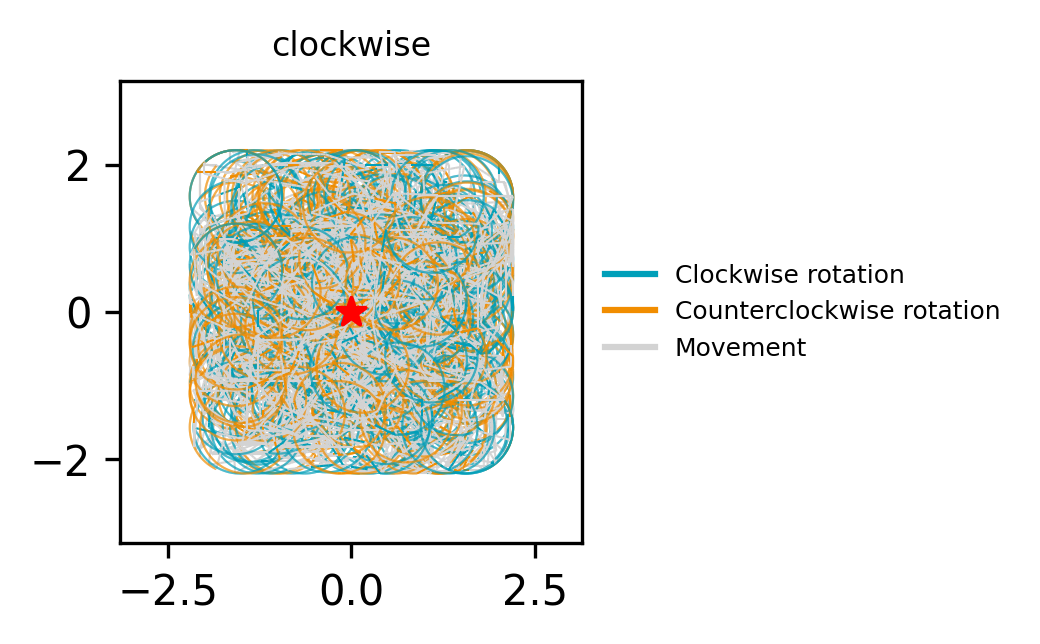

In [4]:
# Seed for reproducibility
# np.random.seed(111)
goal_loc = [0.0*np.pi, 0.0*np.pi]

goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

results = simulate_honeycomb_movement(total_time=400, 
                                    dt=0.01, 
                                    move_prob=0.80, 
                                    drift_factor=0.0, 
                                    velocity=20,
                                    rotation_speed=np.pi / 50,
                                    stick_length = 0.2,
                                    goal_loc=goal_loc_in_traj)

Animal_center_all, Animal_location_all, Head_direction_all, MV_direction_all, Dir2Goal_all, Animal_speed_all, rotation_phases, time_upsampled, Animal_Vel_all, Rotation_direction_all, break_indices = results


Animal_center_all = Animal_center_all*np.pi-0.5*np.pi
Animal_location_all = Animal_location_all*np.pi-0.5*np.pi
Animal_speed_all /= 1000

fig, ax = plt.subplots(1, 1, figsize=(2, 2), dpi=300)

# Create line segments and assign colours
segments = np.array([
    [Animal_location_all[i], Animal_location_all[i + 1]] 
    for i in range(len(Animal_location_all) - 1)
])

colors = []
for i in range(len(Animal_location_all) - 1):
    if rotation_phases[i]:
        if Rotation_direction_all[i] == 1:
            colors.append('#009FB9')   # Clockwise: blue
        elif Rotation_direction_all[i] == -1:
            colors.append('#F18D00')   # Counterclockwise: orange
        else:
            colors.append('lightgrey')  # Should not occur
    else:
        colors.append('lightgrey')      # Movement phase

# Add to plot
lc = LineCollection(segments, colors=colors, linewidths=0.5, alpha=1)
ax.add_collection(lc)
ax.set_aspect('equal')
ax.set_xlim(-np.pi, np.pi)
ax.set_ylim(-np.pi, np.pi)

# Plot goal location
ax.scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=50, zorder=10)

ax.set_title(direction, fontsize=8)

# Define custom legend handles
legend_elements = [
    Line2D([0], [0], color='#009FB9', lw=1.5, label='Clockwise rotation'),
    Line2D([0], [0], color='#F18D00', lw=1.5, label='Counterclockwise rotation'),
    Line2D([0], [0], color='lightgrey', lw=1.5, label='Movement')
]

# Add legend outside the plot box (right side)
ax.legend(handles=legend_elements, 
          loc='center left', 
          bbox_to_anchor=(1.0, 0.5), 
          frameon=False, 
          fontsize=6)

plt.tight_layout()

In [5]:
def get_relativeDir2Goal(Animal_location, Head_direction, goal_loc):
    """
    Compute the relative direction to the goal for each position and head direction.
    
    Parameters:
    - Animal_location_all: Array of animal positions (Nx2).
    - Head_direction_all: Array of head directions (N,).
    - goal_loc: Goal location as a 2D array [x, y].
    
    Returns:
    - relative_angle2goal: Array of relative angles to the goal (N,).
    """

    # Ensure goal_loc is a numpy array
    goal_loc = np.array(goal_loc)

    # Vector from current position to consink
    vec = goal_loc - Animal_location  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    relative_angle2goal = (vec_angle - Head_direction + np.pi) % (2 * np.pi) - np.pi
        
    return relative_angle2goal

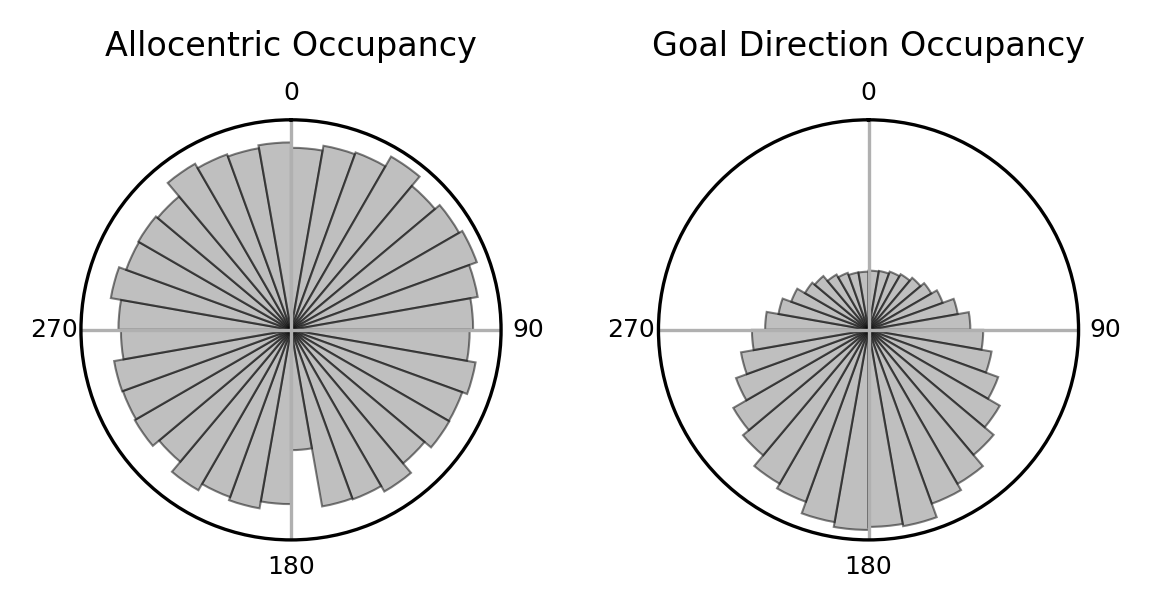

In [6]:
#polor plot of all head direction
fig = plt.figure(figsize=(4, 2), dpi=300)

gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0], projection='polar')

ax1.hist(Head_direction_all[Rotation_direction_all!=0], bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
ax1.set_title('Allocentric Occupancy', fontsize=8)


ax2 = fig.add_subplot(gs[1], projection='polar')

#get relative angles to the goal
relative_angle = get_relativeDir2Goal(Animal_location_all, Head_direction_all, goal_loc)
# relative_angle = get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

ax2.hist(relative_angle, bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
ax2.set_title('Goal Direction Occupancy', fontsize=8)

for ax in [ax1, ax2]:
    # Polar aesthetics
    ax.set_theta_zero_location('N')  # 0 at top
    ax.set_theta_direction(-1)       # clockwise
    #only show 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    #remove y ticks
    ax.set_yticks([])
    #xtick fontsize as 6
    ax.tick_params(labelsize=6)
    ax.xaxis.set_tick_params(pad=-4)
    
plt.tight_layout()



In [7]:
#set simulation parameters
bm.set_platform('gpu')
bm.set_dt(1.0) #ms
bm.clear_buffer_memory(platform='gpu')

v0 = 1.0*bm.pi/1000  #baseline speed
mbar_hd = 5 #5. #HD adaptation strength 
mbar_pc = 5 #5. #GC adaptation strength
noise_stre = 0.
Phase_Offset = 1.5 #1.5
theta_hd_modulation = 0#0.4 # default 0.4; maximal 0.4
theta_gc_modulation = 0#0.8 # default 0.5; maximal 0.5,
Topdown_mod = 5.0 # strength of topdown modulation


#construct the model
#layer 1
HD_net = HD_cell_L1(num=100, 
                    noise_stre = noise_stre/6, #gc has muhc more neurons than hd, 10000 vs 100
                    tau=10., 
                    tau_v=100., 
                    k=1., 
                    mbar=mbar_hd, 
                    a=0.4, 
                    A=3., 
                    J0=4., 
                    z_min=-bm.pi, 
                    z_max=bm.pi, 
                    goal_a=0.4, 
                    goal_A=3.0, 
                    topdown=False)

#layer 2
PC_net = PC_cell_L2(noise_stre = noise_stre,
                    num=50,
                    tau = 10.,
                    tau_v = 100.,
                    mbar = mbar_pc,
                    a = 0.5,
                    A = 5, 
                    td_A = 5,
                    J0 = 10.0,
                    k = 1.0,
                    g = 1000,
                    x_min=-bm.pi,
                    x_max=bm.pi,    
                    num_hd = 100,
                    Phase_Offset = Phase_Offset)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Animal_speed, Dir2Goal): 
    
    A_modulation = (2+Animal_speed/v0)/5
    theta_modulation_stre_hd = theta_hd_modulation * Animal_speed / v0
    theta_modulation_stre_gc = theta_gc_modulation * Animal_speed / v0

    T_theta = 100 #100ms a cycle, i.e., 10 Hz a second
    #calculate TheataModulator at time step i for HD and GC
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta 
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = (1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)) * A_modulation
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD, Topdown_mod, Dir2Goal)
    HD_bumpcenter = HD_net.center #center of mass of internal direction
    HD_bumpactivity = HD_net.r 
    # print(HD_activity.shape)
        
    #update the grid cell network 
    PC_net.step_run(i, Animal_location, HD_bumpactivity, ThetaModulator_GC, Head_direction)
    
    #get results
    PC_bumpcenter = PC_net.center_bump
    PC_bumpactivity = PC_net.r
    return PC_bumpcenter, HD_bumpcenter, PC_bumpactivity, HD_bumpactivity, theta_phase, ThetaModulator_HD

time_steps = np.arange(len(Animal_location_all))
print('Running simulation...')

@bm.jit
def run(time, pos, hd, speed, d2g):
    return bm.for_loop(run_CoupleNet, (time, pos, hd, speed, d2g))

# pc_activity, pc_bumpcenter, theta_phase, theta_rhythm= bm.for_loop(runNet, (time_steps, Position, Speed))
simulate_time = 50000  #every 50s perform the simulation, otherwise the gpu will run out of memory 

# Pre-allocate arrays
pc_activity = np.empty((len(Animal_location_all), 50, 50))
hd_activity = np.empty((len(Animal_location_all), 100))
pc_bumpcenter = np.empty((len(Animal_location_all), 2))
hd_bumpcenter = np.empty((len(Animal_location_all), 1))
theta_phase = np.empty(len(Animal_location_all))
theta_rhythm = np.empty(len(Animal_location_all))

for i in range(0, len(Animal_location_all), simulate_time):
    print('Simulation progress: %.0f%%' % (i/len(Animal_location_all)*100))
    pc_bumpcenter_i, hd_bumpcenter_i, pc_activity_i, hd_activity_i, theta_phase_i, theta_rhythm_i = run(time_steps[i:i+simulate_time], 
                                                                                                        Animal_location_all[i:i+simulate_time], 
                                                                                                        MV_direction_all[i:i+simulate_time],
                                                                                                        Animal_speed_all[i:i+simulate_time],
                                                                                                        Dir2Goal_all[i:i+simulate_time])
    #send data to cpu and store them
    pc_activity[i:i+simulate_time,:,:] = np.asarray(pc_activity_i).reshape((-1,50,50))
    hd_activity[i:i+simulate_time,:] = np.asarray(hd_activity_i)
    pc_bumpcenter[i:i+simulate_time,:] = np.asarray(pc_bumpcenter_i)
    hd_bumpcenter[i:i+simulate_time,:] = np.asarray(hd_bumpcenter_i)
    theta_phase[i:i+simulate_time] = np.asarray(theta_phase_i)
    theta_rhythm[i:i+simulate_time] = np.asarray(theta_rhythm_i)

Running simulation...
Simulation progress: 0%
Simulation progress: 13%
Simulation progress: 25%
Simulation progress: 38%
Simulation progress: 50%
Simulation progress: 63%
Simulation progress: 75%
Simulation progress: 88%


## Section 3: Check anticipatory coding

In [8]:


def get_anticipatory(pc_activity_i, relative_angle, rotation_direction, direction='clockwise', num_bins=36, normalize_rate=False):
    """
    Compute the anticipatory activity of place cells based on relative angles.

    Parameters:
    - pc_activity_i: 1D array of place cell activity.
    - relative_angle: 1D array of relative angles.
    - rotation_direction: 1D array of rotation direction flags (e.g., 1 for CW, -1 for CCW, 0 for stationary).
    - direction: 'clockwise', 'counter_clockwise', or 'nonscanning'
    - num_bins: Number of angular bins.

    Returns:
    - binned_activity: Summed activity per angle bin.
    - dwell_time_per_bin: Number of samples per bin.
    """

    # Filter based on specified rotation direction
    if direction == 'clockwise':
        mask = rotation_direction == 1
    elif direction == 'counter_clockwise':
        mask = rotation_direction == -1
    elif direction == 'nonscanning':
        mask = rotation_direction == 0
    else:
        raise ValueError("Invalid direction. Use 'clockwise', 'counter_clockwise', or 'nonscanning'.")

    activity = pc_activity_i[mask]
    angles = relative_angle[mask]

    # Define bins and digitise
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_indices = np.digitize(angles, angle_bins) - 1

    # Clip to valid bin range
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)

    # Initialise outputs
    binned_activity = np.zeros(num_bins)
    dwell_time_per_bin = np.zeros(num_bins)

    # Accumulate values efficiently
    np.add.at(binned_activity, bin_indices, activity)
    np.add.at(dwell_time_per_bin, bin_indices, 1)

    if normalize_rate==True:
        return binned_activity/dwell_time_per_bin
    else:
        return binned_activity
    


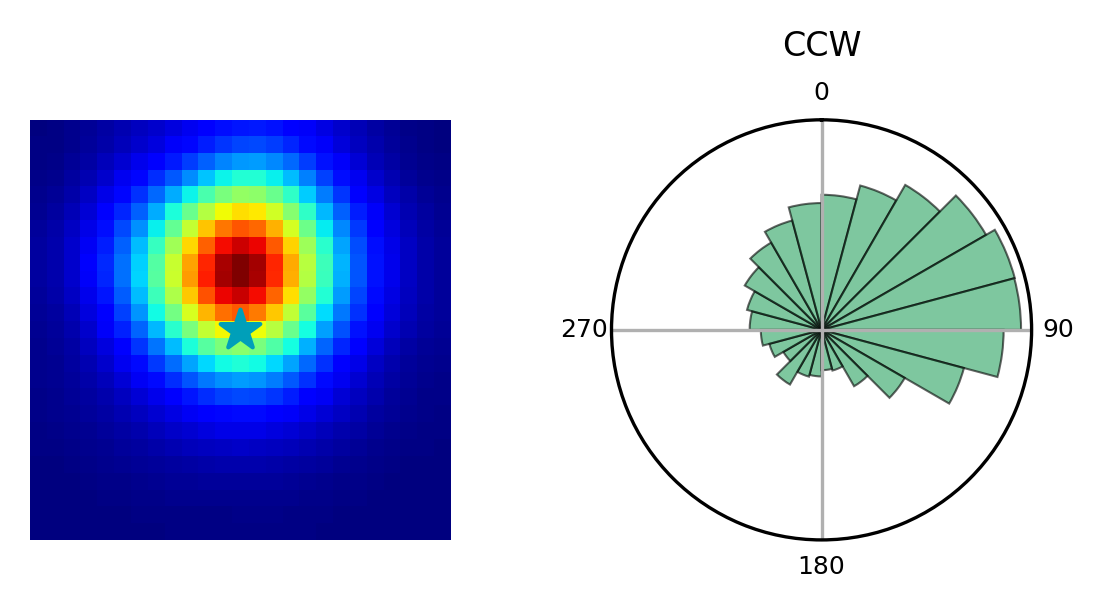

In [20]:
cellindex = [25, 30]
num = 50
num_bins = 24
normalize_rate = True

# direction='clockwise'
direction='counter_clockwise'

pc_activity_i=pc_activity[:, cellindex[0], cellindex[1]]

#cloclwise
relative_angle= get_relativeDir2Goal(Animal_location_all, Head_direction_all, goal_loc)
# relative_angle= get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

# Compute anticipatory activity for clockwise direction
binned_activity = get_anticipatory(pc_activity_i, 
                                   relative_angle, 
                                   Rotation_direction_all, 
                                   direction=direction, 
                                   num_bins=num_bins, 
                                   normalize_rate=normalize_rate)

# Define bins for relative angles from -π to π

angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers
# Close the circle by repeating first value at the end
theta = np.append(bin_centers, bin_centers[0])
binned_activity = np.append(binned_activity, binned_activity[0])
# Create polar plot

fig = plt.figure(figsize=(4, 2), dpi=300)

gs = gridspec.GridSpec(1, 2)

ax = fig.add_subplot(gs[0])

Position_norm = (Animal_location_all - Animal_location_all.min()-1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)

ax.imshow(tuningMap, origin='lower', cmap='jet')

#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)

ax.scatter(goal_x, goal_y, color='#009FB9', marker='*', s=100)

ax.set_aspect('equal')

ax.axis('off')

ax = fig.add_subplot(gs[1], projection='polar')

if direction=='clockwise':
    color='#2167AC'
elif direction=='counter_clockwise':
    color='#28A25F'

bars = ax.bar(
    bin_centers,
    binned_activity[:-1],  # exclude the repeated value
    width=2 * np.pi / num_bins,
    bottom=0.0,
    color=color, #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

if direction == 'clockwise':
    ax.set_title('CW', fontsize=8)
elif direction == 'counter_clockwise':
    ax.set_title('CCW', fontsize=8)
# Set the radial limits

#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/anticipatory_Acell.pdf', bbox_inches='tight', dpi=300)


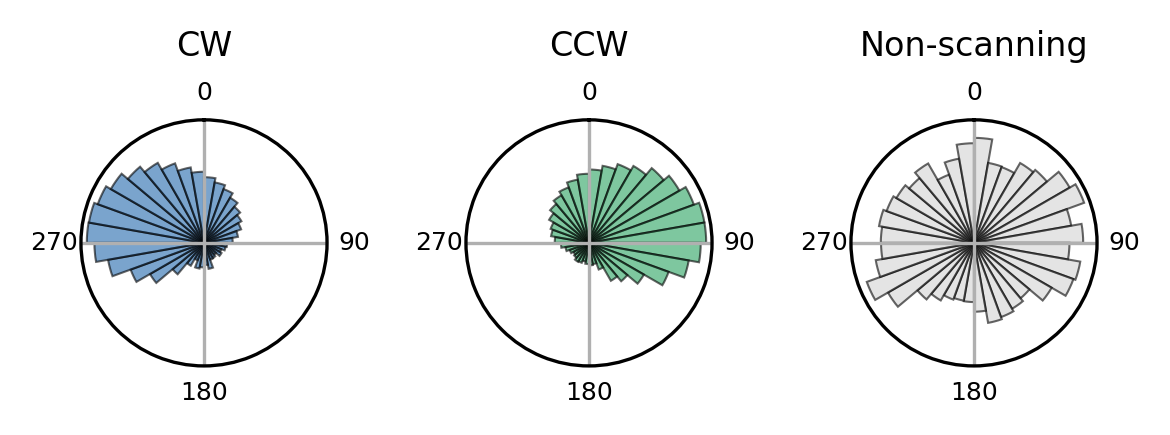

In [19]:
# Define the range of cell indices
start_idx = 20
end_idx = 30  # inclusive

# Define bins for relative angles from -π to π
num_bins =36
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

#get relative angles to the goal
relative_angle = get_relativeDir2Goal(Animal_location_all, Head_direction_all, goal_loc)
# relative_angle = get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

total_binned_activity_cw = np.zeros(num_bins)  
total_binned_activity_ccw = np.zeros(num_bins)  
total_binned_activity_ns = np.zeros(num_bins) 
 
# Loop through the specified submatrix of cells
for i in range(start_idx, end_idx + 1):
    for j in range(start_idx, end_idx + 1):
        pc_activity_ij = pc_activity[:, i, j]
        
        #cloclwise
        direction = 'clockwise'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, Rotation_direction_all, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_cw += binned_activity  # Accumulate the binned activity across all cells

        #counterclockwise
        direction = 'counter_clockwise'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, Rotation_direction_all, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_ccw += binned_activity  # Accumulate the binned activity across all cells
        
        # nonscanning
        direction = 'nonscanning'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, Rotation_direction_all, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_ns += binned_activity  # Accumulate the binned activity across all cells
        
# Convert bin centers to polar coordinates
theta = np.append(bin_centers, bin_centers[0])

total_binned_activity_cw = np.append(total_binned_activity_cw, total_binned_activity_cw[0])
total_binned_activity_ccw = np.append(total_binned_activity_ccw, total_binned_activity_ccw[0])
total_binned_activity_ns = np.append(total_binned_activity_ns, total_binned_activity_ns[0])

# Bar width based on bin size
bar_width = 2 * np.pi / num_bins

# Create polar plot with bars instead of line
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(4, 2), dpi=300)

ax = axs[0]

bars = ax.bar(
    bin_centers,
    total_binned_activity_cw[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#2167AC', #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
#set title
ax.set_title("CW", fontsize=8)

ax = axs[1]
bars = ax.bar(
    bin_centers,
    total_binned_activity_ccw[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#28A25F', #orange
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("CCW", fontsize=8)

ax = axs[2]
bars = ax.bar(
    bin_centers,
    total_binned_activity_ns[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='lightgrey',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("Non-scanning", fontsize=8)

for ax in axs:
    # Polar aesthetics
    ax.set_theta_zero_location('N')  # 0 at top
    ax.set_theta_direction(-1)       # clockwise
    #only show 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    ax.set_xticklabels(['0', '90', '180', '270'])
    #remove y ticks
    ax.set_yticks([])
    #xtick fontsize as 6
    ax.tick_params(labelsize=6)
    ax.xaxis.set_tick_params(pad=-4) 

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/anticipatory_Allcell.pdf', bbox_inches='tight', dpi=300)

## Section4: Check consink cell (see Ormond&OKeefe 2022 Nature)

In [11]:
def getSpike_RelativeDirection(consink_loc, Animal_location, Head_direction, spikes):
    """
    Computes the relative direction (in radians) between the head direction and the vector
    pointing from the current position to a candidate sink location, for timepoints where spikes occurred.

    Returns:
        RelativeDirection (ndarray): Vector of relative angles in radians.
        r (float): Mean vector length.
    """
    # Only retain timepoints where spikes occurred
    mask = spikes > 0
    if not np.any(mask):
        return np.array([]), 0.0  # No spikes -> return r=0

    pos = Animal_location[mask]
    hd = Head_direction[mask]

    # Vector from current position to consink
    vec = consink_loc - pos  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    angle_diff = (hd - vec_angle + np.pi) % (2 * np.pi) - np.pi

    # Mean vector length
    r = cd.resultant_vector_length(angle_diff)

    return angle_diff, r

def get_best_consink_location(consink_x, consink_y, Animal_location_all, Head_direction_all, spikes, top_k=10):
    """
    Perform a grid search over candidate sink locations to find the one that maximises 
    the mean resultant length (MRL), and return the average location of the top K sinks.

    Parameters:
        consink_x (np.ndarray): Candidate sink x-coordinates.
        consink_y (np.ndarray): Candidate sink y-coordinates.
        Animal_location_all (np.ndarray): Animal positions at all timepoints.
        Head_direction_all (np.ndarray): Head directions at all timepoints.
        spikes (np.ndarray): Spike counts at all timepoints.
        top_k (int): Number of top MRLs to average for final sink location.

    Returns:
        mean_sink_loc (np.ndarray): Mean coordinates of top-K sink locations by MRL.
        best_mrl (float): Highest MRL value among all candidates.
        best_RelativeDirection (np.ndarray): Relative direction corresponding to the highest MRL.
        all_mrls (list): All MRL values in grid order.
        all_sinks (list): All sink coordinates in grid order.
    """
    best_mrl = -np.inf
    best_RelativeDirection = None
    all_mrls = []
    all_sinks = []

    for cx in consink_x:
        for cy in consink_y:
            consink_loc = np.array([cx, cy])
            RelativeDirection, mrl_val = getSpike_RelativeDirection(
                consink_loc, Animal_location_all, Head_direction_all, spikes
            )
            all_mrls.append(mrl_val)
            all_sinks.append(consink_loc)

            if mrl_val > best_mrl:
                best_mrl = mrl_val
                best_RelativeDirection = RelativeDirection

    # Convert to arrays for indexing
    all_mrls = np.array(all_mrls)
    all_sinks = np.array(all_sinks)

    # Get indices of top K MRLs
    if len(all_mrls) >= top_k:
        top_indices = np.argsort(all_mrls)[-top_k:]
        mean_sink_loc = np.mean(all_sinks[top_indices], axis=0)
    else:
        mean_sink_loc = np.mean(all_sinks, axis=0)  # fallback if < top_k points

    return mean_sink_loc, best_mrl, best_RelativeDirection


def compute_dwell_normalised_activity(best_RelativeDirection, spikes, num_bins=36):
    
    # Dewell time
    num_bins = 36
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

    bin_indices = np.digitize(best_RelativeDirection, angle_bins) - 1
    # Clip to valid bin range
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)
    dwell_time_per_bin = np.zeros(num_bins)
    spikes_per_bin = np.zeros(num_bins)
    np.add.at(dwell_time_per_bin, bin_indices, 1)
    mask = spikes > 0  # Only consider timepoints with spikes
    np.add.at(spikes_per_bin, bin_indices, spikes[mask])
    activity_per_bin = spikes_per_bin / dwell_time_per_bin
    
    return activity_per_bin, bin_centers



### calculate the best consink location for a cell and compare the relative direction to consink, goal and a random location 

Best consink location: [0.95901249 0.66138793]
Max mean vector length (r): 0.079


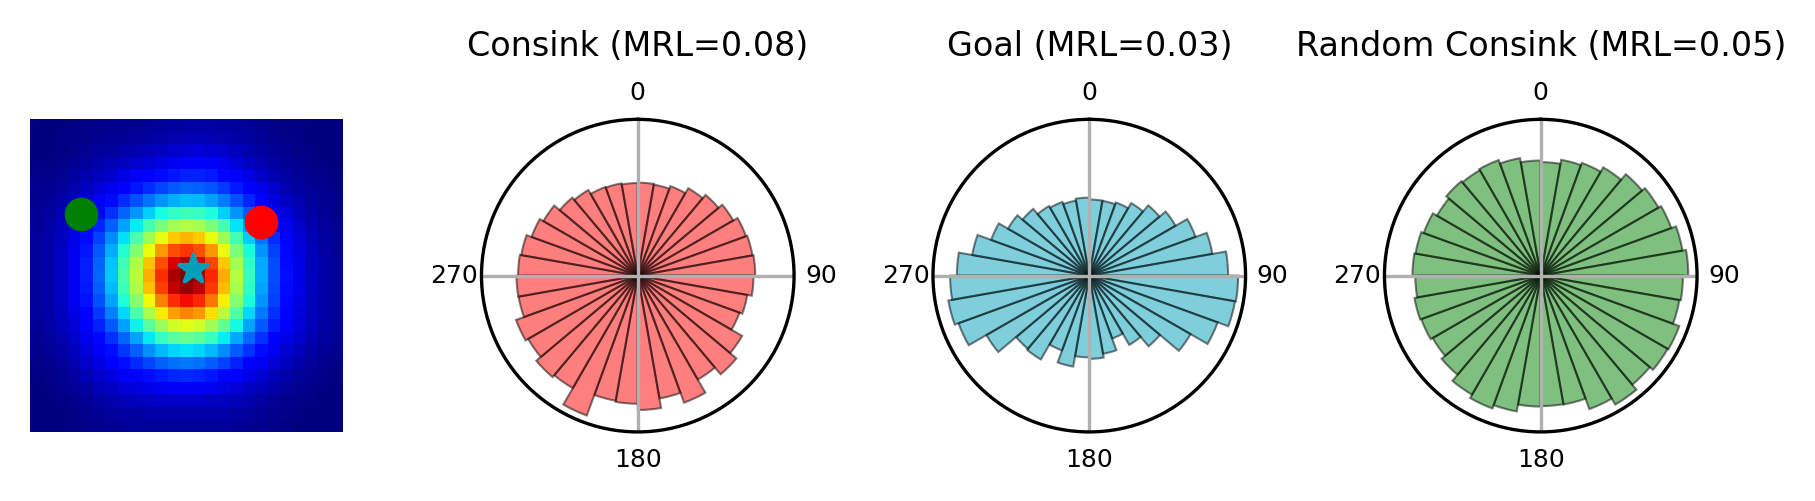

In [12]:
bins = 36

cellindex = [25, 25]  # example cell index

# Sink location grid search parameters
consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)
consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)

r = pc_activity[:, cellindex[0], cellindex[1]]  # firing rate for this cell
# Note the model is a rate-based model so that we need to generate Poisson spike train and 
# for each spike time point, we get the relative direction to the goal
spikes = np.random.poisson(r)
            
best_sink, best_mrl, best_RelativeDirection = get_best_consink_location(consink_x, consink_y,
                                                                      Animal_location_all, 
                                                                      Head_direction_all, 
                                                                      spikes,
                                                                      top_k=10)


print(f"Best consink location: {best_sink}")
print(f"Max mean vector length (r): {best_mrl:.3f}")

#ConSink plot
fig = plt.figure(figsize=(6, 2), dpi=300)

gs = gridspec.GridSpec(1, 4)

#-----------------plot place cell firing field and add consink, goal location---------------
ax1 = fig.add_subplot(gs[0])

Position_norm = (Animal_location_all - Animal_location_all.min() - 1e-5)/(Animal_location_all.max() - Animal_location_all.min())
dim = num//2
tuningMap = get_tuningMap(pc_activity, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          shift = 0,
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)
ax1.imshow(tuningMap, cmap='jet', origin='lower')

#mark the goal location
goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
ax1.scatter(goal_x, goal_y, color='#009FB9', marker='*', s=50, label='Goal')

# mark the best sink location
sink_x = (best_sink[0] - Animal_location_all.min()) / (Animal_location_all.max() - Animal_location_all.min()) * dim
sink_y = (best_sink[1] - Animal_location_all.min()) / (Animal_location_all.max() - Animal_location_all.min()) * dim
ax1.scatter(sink_x, sink_y, color='red', marker='o', s=50, label='Consink')

ax1.axis('off')


#-----------------calculate relative direction to consink------------------
ax = fig.add_subplot(gs[1], projection='polar')


if normalize_rate == False:
    #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as Non
    ax.hist(best_RelativeDirection, bins=36, color='red', edgecolor='black', linewidth=0.5, alpha=0.5)
else:
    # Compute dwell-normalised activity
    activity_per_bin, bin_centers = compute_dwell_normalised_activity(best_RelativeDirection, spikes, num_bins=bins)
    bars = ax.bar(
        bin_centers,
        activity_per_bin,  # exclude the repeated value
        width=2 * np.pi / num_bins,
        bottom=0.0,
        color='red', #'#2167AC', #28A25F
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title('Consink (MRL=%.2f)' % best_mrl, fontsize=8)

ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 
    
#----------------calcluate relative direction to goal------------------
ax = fig.add_subplot(gs[2], projection='polar')

RelativeDirection2Goal, r_val = getSpike_RelativeDirection(
    goal_loc, Animal_location_all, Head_direction_all, spikes
)

# RelativeDirection2Goal, r_val = getSpike_RelativeDirection(
#     goal_loc, Animal_center_all, Head_direction_all, spikes
# )

if normalize_rate == False:
    #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
    ax.hist(RelativeDirection2Goal, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.5, alpha=0.5)
else:
    # Compute dwell-normalised activity
    activity_per_bin, bin_centers = compute_dwell_normalised_activity(RelativeDirection2Goal, spikes, num_bins=bins)
    bars = ax.bar(
        bin_centers,
        activity_per_bin,  # exclude the repeated value
        width=2 * np.pi / num_bins,
        bottom=0.0,
        color='#009FB9', #'#2167AC', #28A25F
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title('Goal (MRL=%.2f)' % r_val, fontsize=8)

ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

#----------------calcluate relative direction to a random consink------------------
ax = fig.add_subplot(gs[3], projection='polar')

random_consink_loc = (-0.5 * np.pi, 0.25 * np.pi)

random_consink_loc_x = (random_consink_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim
random_consink_loc_y = (random_consink_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*dim

#add random consink location to the place field plot
ax1.scatter(random_consink_loc_x, random_consink_loc_y, color='green', marker='o', s=50, label='Consink')

RelativeDirection2RS, r_val = getSpike_RelativeDirection(
    random_consink_loc, Animal_location_all, Head_direction_all, spikes
)

# RelativeDirection2RS, r_val = getSpike_RelativeDirection(
#     random_consink_loc, Animal_center_all, Head_direction_all, spikes
# )


if normalize_rate == False:
    #plot RelativeDirection histogram as a polar plot, with edgecolor as black, facecolor as None
    ax.hist(RelativeDirection2RS, bins=bins, color='green', edgecolor='black', linewidth=0.5, alpha=0.5)
else:
    # Compute dwell-normalised activity
    activity_per_bin, bin_centers = compute_dwell_normalised_activity(RelativeDirection2RS, spikes, num_bins=bins)
    bars = ax.bar(
        bin_centers,
        activity_per_bin,  # exclude the repeated value
        width=2 * np.pi / num_bins,
        bottom=0.0,
        color='green', #'#2167AC', #28A25F
        alpha=0.6,
        edgecolor='black',
        linewidth=0.5
    )

ax.set_title('Random Consink (MRL=%.2f)' % r_val, fontsize=8)

ax.set_theta_zero_location('N')  # 0 at top
ax.set_theta_direction(-1)       # clockwise
#only show 0, 90, 180, 270
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/PaperFig/ConSinkCell.pdf', bbox_inches='tight', dpi=300)


### get the best sink for all cells

In [13]:
consink_x = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)
consink_y = np.linspace(-0.5 * np.pi, 0.5 * np.pi, 20)

start_idx = 25
end_idx = 35  # inclusive

Best_MRLs_activeScan = []
Best_Sinks_activeScan  = []

Best_MRLs_inactiveScan = []
Best_Sinks_inactiveScan  = []

for ii in range(start_idx, end_idx + 1, 3):
    for jj in range(start_idx, end_idx + 1, 3):
        
        # print(ii, jj)
        r = pc_activity[:, ii, jj]  # firing rate for this cell
        spikes = np.random.poisson(r)

        # Get the best consink location for this cell during activate scanning
        results = get_best_consink_location(consink_x, consink_y,
                                            Animal_location_all[Rotation_direction_all!=0],
                                            Head_direction_all[Rotation_direction_all!=0],
                                            spikes[Rotation_direction_all!=0],
                                            top_k=10)
        
        best_sink, best_mrl, best_RelativeDirection = results
        # Store results
        Best_MRLs_activeScan.append(best_mrl)
        Best_Sinks_activeScan.append(best_sink)

        # Get the best consink location for this cell during inactive scanning
        results = get_best_consink_location(consink_x, consink_y,
                                            Animal_location_all[Rotation_direction_all==0],
                                            Head_direction_all[Rotation_direction_all==0],
                                            spikes[Rotation_direction_all==0],
                                            top_k=10)
        
        best_sink, best_mrl, best_RelativeDirection = results
        # Store results
        Best_MRLs_inactiveScan.append(best_mrl)
        Best_Sinks_inactiveScan.append(best_sink)
        
# for r in AllR:
#     plt.figure()
#     plt.hist(r)

Max MRL 0.16436532142375634
Max MRL 0.27819385870958463


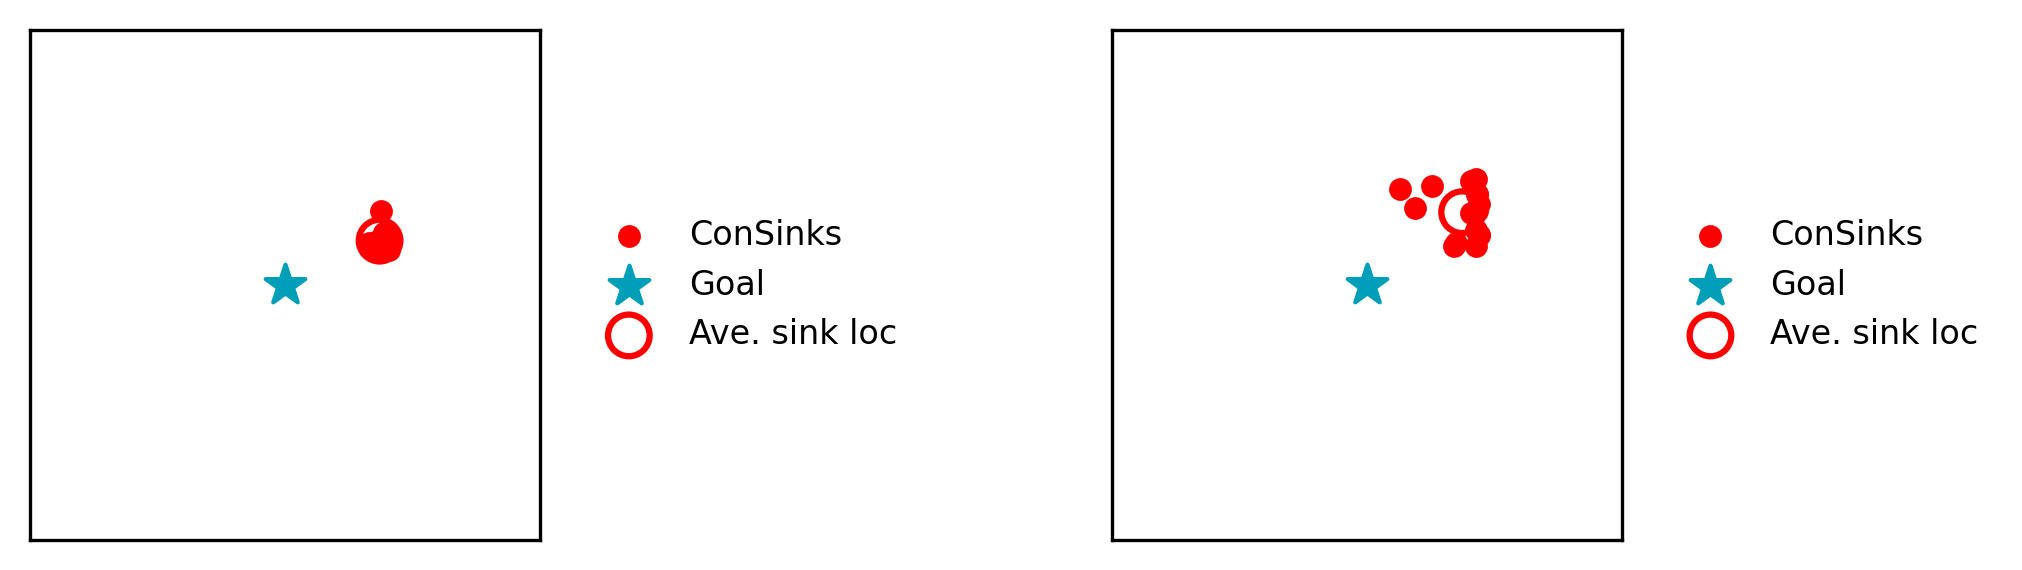

In [14]:
# Prepare figure
fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 2)

ax0 = fig.add_subplot(gs[0])

# Convert to arrays
Best_Sinks_activeScan = np.array(Best_Sinks_activeScan)
Best_MRLs_activeScan = np.array(Best_MRLs_activeScan)

print('Max MRL', np.mean(Best_MRLs_activeScan))

for i, sink in enumerate(Best_Sinks_activeScan):
    if i == 0:
        ax0.scatter(sink[0], sink[1], color='red', marker='o', s=20, label='ConSinks')
    else:
        ax0.scatter(sink[0], sink[1], color='red', marker='o', s=20)

ax0.scatter(goal_loc[0], goal_loc[1], color='#009FB9', marker='*', s=100, label='Goal')

# Compute and plot mean best sink (blue star)
mean_sink = np.mean(np.vstack(Best_Sinks_activeScan), axis=0)
ax0.scatter(mean_sink[0], mean_sink[1], facecolors='none', edgecolors='red', marker='o', s=100, linewidth=1.5, label='Ave. sink loc')

#---------------------------------

ax1 = fig.add_subplot(gs[1])

# Convert to arrays
Best_Sinks_inactiveScan = np.array(Best_Sinks_inactiveScan)
Best_MRLs_inactiveScan = np.array(Best_MRLs_inactiveScan)

print('Max MRL', np.mean(Best_MRLs_inactiveScan))

for i, sink in enumerate(Best_Sinks_inactiveScan):
    if i == 0:
        ax1.scatter(sink[0], sink[1], color='red', marker='o', s=20, label='ConSinks')
    else:
        ax1.scatter(sink[0], sink[1], color='red', marker='o', s=20)

ax1.scatter(goal_loc[0], goal_loc[1], color='#009FB9', marker='*', s=100, label='Goal')

# Compute and plot mean best sink (blue star)
mean_sink = np.mean(np.vstack(Best_Sinks_inactiveScan), axis=0)
ax1.scatter(mean_sink[0], mean_sink[1], facecolors='none', edgecolors='red', marker='o', s=100, linewidth=1.5, label='Ave. sink loc')


for ax in [ax0, ax1]:
    ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.05, 0.5), frameon=False)

    ax.set_xlim(-0.8*np.pi, 0.8*np.pi)
    ax.set_ylim(-0.8*np.pi, 0.8*np.pi)
    ax.set_aspect('equal')
    #ticks off
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HoneycombSweeps/figures/ConSinkMap_'+str(goal_loc[0]/np.pi)+'_'+str(goal_loc[1]/np.pi)+'.pdf')